# IT1244 Project: Airlines Sentiment Clustering
#### By: Gerald James Low Ming Tuck, Jayden Lim, Lim Zhao Xun Jerrell, Tan Min Kai, Edsel


Important to run this as it does not come pre-installed.

In [5]:
!pip install scikit-learn-extra

Here are the packages we will be using. Note that we do not end up using all of them.

In [6]:
import pandas as pd
import re
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import nltk
from nltk.stem import LancasterStemmer
nltk.download('punkt')
nltk.download('stopwords')
## May need to run this first on your device: nltk.download("stopwords")
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.cluster import Birch
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn_extra.cluster import KMedoids
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Here is a list of all the airport codes. We will put everything in lower case and use it as a filter later.

In [7]:
us_airport_codes = [
    "ATL", "LAX", "ORD", "DFW", "DEN", "JFK", "SFO", "LAS", "SEA", "MIA",
    "MCO", "PHX", "IAH", "CLT", "EWR", "MSP", "BOS", "DTW", "PHL", "LGA",
    "FLL", "BWI", "DCA", "MDW", "SLC", "HNL", "SAN", "TPA", "DAL", "HOU",
    "AUS", "STL", "RDU", "BNA", "SJC", "OAK", "SMF", "MSY", "SNA", "PDX",
    "MCI", "SAT", "SJU", "IND", "PIT", "CLE", "CMH", "CVG", "ANC", "JAX",
    "ORF", "RNO", "RIC", "OKC", "OMA", "TUL", "BUF", "ALB", "PBI", "SAV",
    "ABQ", "BHM", "RSW", "MEM", "ONT", "BUR", "LIT", "CHS", "TYS", "TUS",
    "GRR", "SDF", "GSO", "GSP", "PVD", "PWM", "BTR", "MSN", "FAT", "XNA",
    "SYR", "LGB", "ELP", "HSV", "ROA", "TLH", "COS", "SHV", "BTV", "PSP",
    "GEG", "BOI", "RAP", "ICT", "GNV", "LEX", "FSD", "FWA", "MLI", "ECP",
    "ACY", "PIE", "LFT", "MHT", "AZO", "BZN", "CAE", "TUL", "ISP", "AGS",
    "TTN", "IAD", "BOZ", "MFR", "ROG", "BZN", "MAF", "MLB", "AVP", "BIL",
    "SRQ", "SBA", "LBB", "EYW", "LAN", "MOB", "CRW", "BIS", "SPI", "ROA",
    "GJT", "JAN", "GTF", "FNT", "TVC", "MGM", "FAR", "HPN", "SFB", "TOL",
    "BGR", "ACT", "CPR", "MFE", "MBS", "LSE", "ERI", "SGF", "TWF", "STT",
    "SAF", "PIA", "GGG", "FSM", "MHK", "HIB", "DBQ", "AEX", "RST", "TRI",
    "BRO", "BQK", "EGE", "ILM", "ABI", "JLN", "CEC", "CSG", "GUC", "EUG",
    "OAJ", "MEI", "BFL", "BKG", "ESC", "ROW", "FLG", "DRO", "CWA", "ACT",
    "AUS", "AVL", "BHM", "BNA", "CHA", "EVV", "GSO", "HSV", "MSY", "TYS"
]

us_airport_codes_lower = [code.lower() for code in us_airport_codes]

This is the start of our preprocessing. Below is a helper function `remove_airport_codes`. The function `clean_text` helps us to remove punctuation, special symbols, digits, hyphen, emojis, and even @ mentions and hastags. The text is then manipulated to be in lowercase. Lastly, the text is being filtered out for any mentions of US airport destinations.

In [8]:
def remove_airport_codes(text, airport_codes):
    # Split the text into individual words
    words = text.split()
    # Filter out any words that are in the airport_codes list
    cleaned_words = [word for word in words if word not in airport_codes]
    # Join the cleaned words back into a sentence
    return ' '.join(cleaned_words)

def clean_text(file):
    # Read the text file
    df = pd.read_csv(file)
    #Remove @ mentions, links, punctuation, airport codes in upper case
    df['text'] = df['text'].apply(lambda x: re.sub(r'@\w+', '', x)) #removes @ and wtv is behind
    df['text'] = df['text'].apply(lambda x: re.sub(r'#\w+', '', x)) #removes # and wtv is behind
    df['text'] = df['text'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE)) #removes links
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x)) #removes non-words, punctuation, special symbols, emojis
    df['text'] = df['text'].apply(lambda x: re.sub(r"(?<=\w)-(?=\w)", " ", x)) #removes hyphen
    df['text'] = df['text'].apply(lambda x: re.sub(r'\d+', '', x)) #removes digits
    df['text'] = df['text'].apply(lambda x: x.lower()) #sends all to lower case
    df['text'] = df['text'].apply(lambda x: remove_airport_codes(x.lower(), us_airport_codes_lower)) #removes singular airport mentions like lax, ord , etc.


    return df



The code below cleans the text and outputs it.

In [9]:
tweetdataraw = clean_text("/content/Tweets.csv")
#tweetdataraw = tweetdataraw.reset_index(drop=True)
tweetdataraw

,airline_sentiment,sentiment_confidence,text
0,neutral,1.0000,what said
1,positive,0.3486,plus youve added commercials to the experience...
2,neutral,0.6837,i didnt today must mean i need to take another...
3,negative,1.0000,its really aggressive to blast obnoxious enter...
4,negative,1.0000,and its a really big bad thing about it
...,...,...,...
14634,positive,0.3487,thank you we got on a different flight to chicago
14635,negative,1.0000,leaving over minutes late flight no warnings o...
14636,neutral,1.0000,please bring american airlines to
14637,negative,1.0000,you have my money you change my flight and don...


Here is a word cloud that displayed common words in various sentiments.

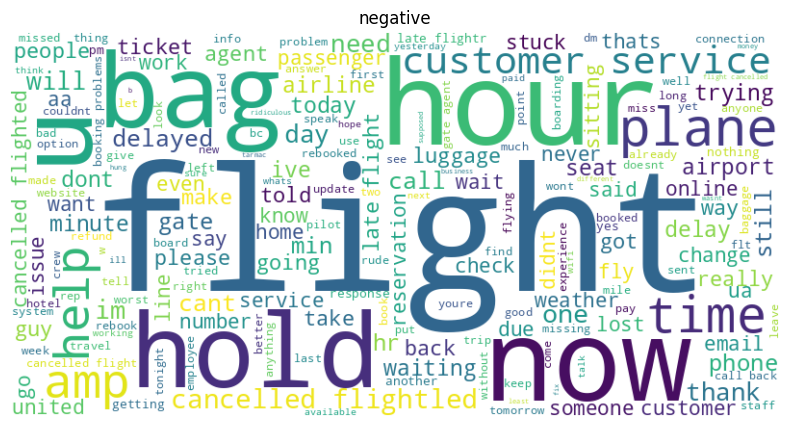

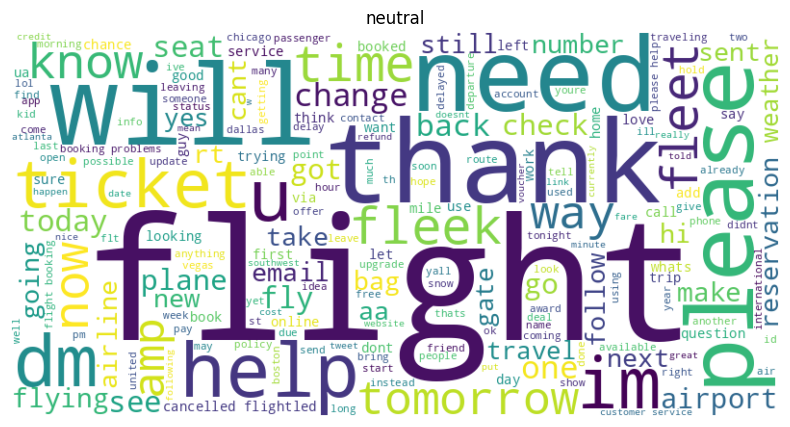

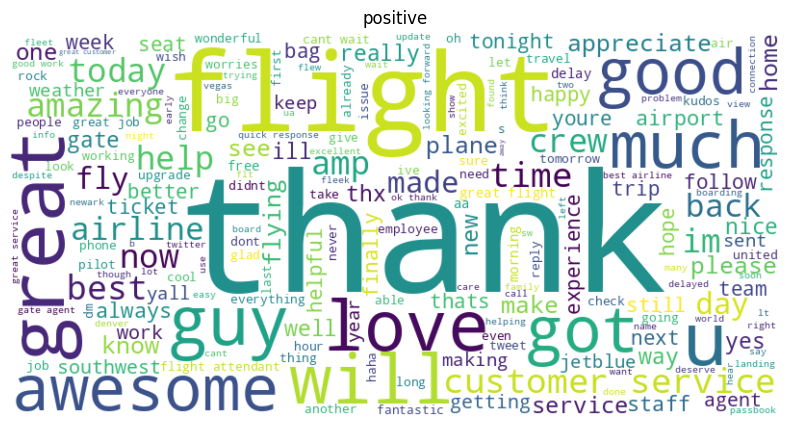

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate and display a word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()


# Group tweets by sentiment
sentiments = tweetdataraw.groupby('airline_sentiment')

# Generate word clouds for each sentiment
for sentiment, data in sentiments:
    text = ' '.join(data['text'])  # Concatenate tweets for each sentiment
    generate_wordcloud(text, sentiment)

Here we are setting up our visualisation and entropy parameters.

In [28]:
def visualiseclusters(X, labtrue, labpred):
    colors = ['red', 'green', 'blue']
    shapes = ['o', '^', 's']

    # Create a scatter plot
    plt.figure(figsize=(10, 10))
    for i in range(len(X)):
        plt.scatter(X[i, 0], X[i, 1], c=colors[labtrue[i]], marker=shapes[labpred[i]], facecolors='none')

    plt.title('t-SNE Visualization of Clusters')
    plt.show()

def entropy(p):
    p = np.clip(p, 1e-15, 1 - 1e-15)  # Avoid log(0)
    return -np.sum(p * np.log2(p))

The code below adds a column that numbers the sentiment. Positive = 0, Negative = 1, Neutral = 0

In [29]:
numericform = []
for index in tweetdataraw.index:  # Iterate using the DataFrame's index
    if tweetdataraw.loc[index, 'airline_sentiment'] == 'positive':
        numericform.append(0)
    if tweetdataraw.loc[index, 'airline_sentiment'] == 'negative':
        numericform.append(1)
    if tweetdataraw.loc[index, 'airline_sentiment'] == 'neutral':
        numericform.append(2)

tweetdataraw['sentiment'] = numericform
tweetdataraw['sentiment']

tweetdataraw

,airline_sentiment,sentiment_confidence,text,sentiment
0,neutral,1.0000,what said,2
1,positive,0.3486,plus youve added commercials to the experience...,0
2,neutral,0.6837,i didnt today must mean i need to take another...,2
3,negative,1.0000,its really aggressive to blast obnoxious enter...,1
4,negative,1.0000,and its a really big bad thing about it,1
...,...,...,...,...
14634,positive,0.3487,thank you we got on a different flight to chicago,0
14635,negative,1.0000,leaving over minutes late flight no warnings o...,1
14636,neutral,1.0000,please bring american airlines to,2
14637,negative,1.0000,you have my money you change my flight and don...,1


Here are our parameters throughout the models:

In [11]:
# Parameters
dim_param = 400
noiseparam1 = 0.4
noiseparam2 = 17

If you are testing saved_models, please stop here! Proceed to the bottom of the Colab to run the models.

We are training a Word2Vec model which is then fed into our Skip Gram model. This converts words and text features into a vector space.

In [38]:
#Train Word2Vec model
stop_words = set(stopwords.words('english')).union({"virginamerica", "united", "southwestair", "jetblue", "usairways", "americanair", "usairway"})
filtered_tweets = tweetdataraw['text'].apply(lambda x: [word for word in x.split() if word not in stop_words])
skip_gram_model = Word2Vec(sentences=filtered_tweets, vector_size=dim_param, window=3, min_count=7, sg=1, workers=4)

##skip_gram_model

Here, we are able to visualise the top 5 similar words, compared to three words of varying sentiments.

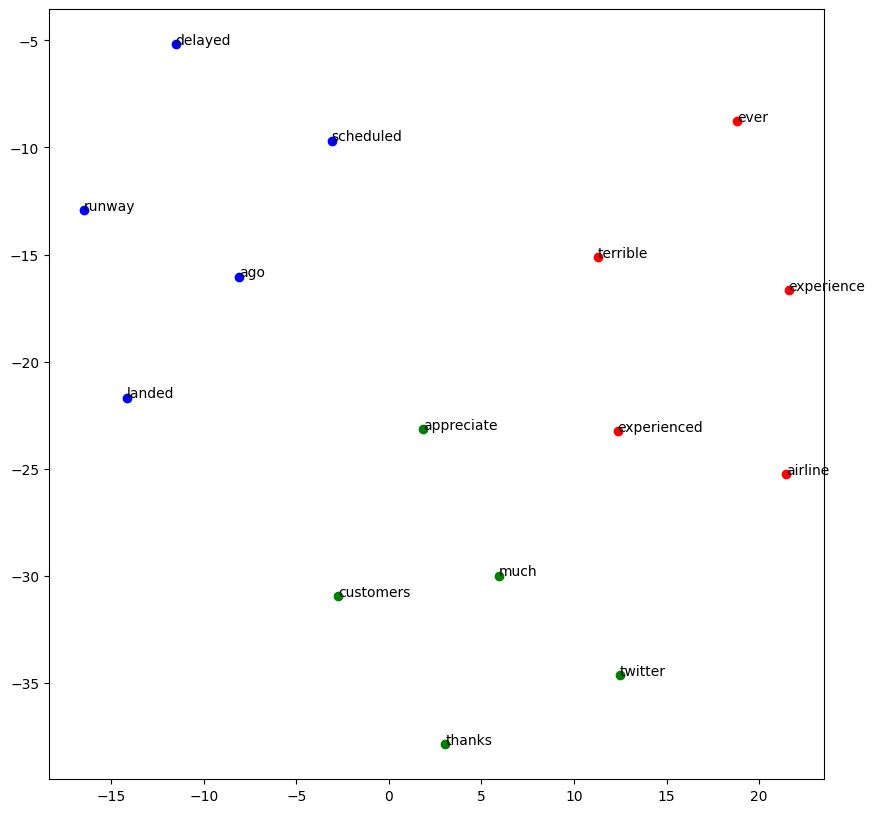

In [13]:
# Predict nearest words
nearest_wordsA = skip_gram_model.wv.most_similar(positive=["worst"], topn=5)
nearest_wordsB = skip_gram_model.wv.most_similar(positive=["thank"], topn=5)
nearest_wordsC = skip_gram_model.wv.most_similar(positive=["late"], topn=5)
tovisualise = [i[0] for i in (nearest_wordsA + nearest_wordsB + nearest_wordsC)]

tsne = TSNE(n_components=2, random_state=0, perplexity = 11)
word_vectors_2d = tsne.fit_transform(skip_gram_model.wv[tovisualise])

# Visualize the embeddings
plt.figure(figsize=(10, 10))
colors = ['red', 'green', 'blue']
for i, word in enumerate(tovisualise):
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1], c = colors[i//5])
    plt.annotate(word, (word_vectors_2d[i, 0], word_vectors_2d[i, 1]))
plt.show()

KMeans algorithm. We used KMedoids here as we are able to tune the metric to the cosine similarity. We are also setting up the embeddings for each word.

In [14]:
kmeans = KMedoids(n_clusters=3, metric = "cosine")

embeddings = []

for tweet in tweetdataraw['text']:
    words = tweet.split()
    in_vocab_words = [word for word in words if word in skip_gram_model.wv.key_to_index]
    if in_vocab_words:
        embedding = np.mean([skip_gram_model.wv[word] for word in in_vocab_words], axis=0)
        embeddings.append(embedding)
    else:
        embeddings.append(np.zeros((dim_param,),dtype=np.float32))


Fitting the embeddings to the kmeans algorithm and getting our metric scores. We will be assessing all our models with the metrics after running all of them. The metrics are: Homogeneity, Completeness, V-Measure, Adjusted Rand Index, Silhouette Coefficient.

In [15]:
embeddings = np.array(embeddings)
kmeans.fit(embeddings)
tweet_clusters = kmeans.labels_

homogeneity = metrics.homogeneity_score(tweetdataraw['sentiment'], tweet_clusters)
completeness = metrics.completeness_score(tweetdataraw['sentiment'], tweet_clusters)
v_measure = metrics.v_measure_score(tweetdataraw['sentiment'], tweet_clusters)
adjusted_rand_index = metrics.adjusted_rand_score(tweetdataraw['sentiment'], tweet_clusters)
silhouette_coefficient = metrics.silhouette_score(embeddings, tweet_clusters, sample_size=2000, metric = 'cosine')


print("--------The following are scores for naive k means clustering (W2V)------------")
print(f"Homogeneity: {homogeneity:.4f}")
print(f"Completeness: {completeness:.4f}")
print(f"V-Measure: {v_measure:.4f}")
print(f"Adjusted Rand Index: {adjusted_rand_index:.4f}")
print(f"Silhouette Coefficient:{silhouette_coefficient:.4f}")
cm = confusion_matrix(tweetdataraw['sentiment'], tweet_clusters)
print(cm)
print(f"Within SS is: {kmeans.inertia_: .4f}")

tsne = TSNE(n_components=2, random_state=0, perplexity = 30)
X_embedded = tsne.fit_transform(embeddings) #convert to 2-d format for visualisation

--------The following are scores for naive k means clustering (W2V)------------
Homogeneity: 0.0668
Completeness: 0.0561
V-Measure: 0.0610
Adjusted Random Index: 0.0464
Silhouette Coefficient:0.2341
[[ 280 1623  459]
 [2669 2392 4117]
 [1001 1410  688]]
Within SS is:  630.4902


Now, here is the Birch model, our other clustering method.

In [16]:
bchModel = Birch(n_clusters = 3, compute_labels = True, threshold=0.45, branching_factor=50)

bchModel.fit(embeddings)
tweet_clusters = bchModel.labels_

homogeneity = metrics.homogeneity_score(tweetdataraw['sentiment'], tweet_clusters)
completeness = metrics.completeness_score(tweetdataraw['sentiment'], tweet_clusters)
v_measure = metrics.v_measure_score(tweetdataraw['sentiment'], tweet_clusters)
adjusted_rand_index = metrics.adjusted_rand_score(tweetdataraw['sentiment'], tweet_clusters)
silhouette_coefficient = metrics.silhouette_score(embeddings, tweet_clusters, sample_size=2000, metric = 'cosine')

print("--------The following are scores for naive Birch clustering (W2V)------------")
print(f"Homogeneity: {homogeneity:.4f}")
print(f"Completeness: {completeness:.4f}")
print(f"V-Measure: {v_measure:.4f}")
print(f"Adjusted Rand Index: {adjusted_rand_index:.4f}")
print(f"Silhouette Coefficient:{silhouette_coefficient:.4f}")
cm = confusion_matrix(tweetdataraw['sentiment'], tweet_clusters)
print(cm)

--------The following are scores for naive Birch clustering (W2V)------------
Homogeneity: 0.0096
Completeness: 0.0509
V-Measure: 0.0161
Adjusted Random Index: 0.0067
Silhouette Coefficient:0.4924
[[2263   14   85]
 [8887   27  264]
 [2979  103   17]]


Now we are using another method for better results, TF-IDF and then running Latent Semantic Analysis on the matrix. This would be our dimensionality reduction technique.

In [17]:
### Try again, with the dimensionality reduction technique
tfidf_vectorizer = TfidfVectorizer(sublinear_tf = True, ngram_range = (1,2))
tfidf_matrix = tfidf_vectorizer.fit_transform(tweetdataraw['text'])

lsa = make_pipeline(TruncatedSVD(n_components=dim_param), Normalizer(copy=False))
tweet_lsa = lsa.fit_transform(tfidf_matrix)

Our implementation of the DBSCAN algorithm and its respective metrics.

In [18]:
db2 = DBSCAN(eps=noiseparam1, min_samples=noiseparam2, metric = "cosine").fit(tweet_lsa)
tweet_clusters = db2.labels_
homogeneity = metrics.homogeneity_score(tweetdataraw['airline_sentiment'], tweet_clusters)
completeness = metrics.completeness_score(tweetdataraw['airline_sentiment'], tweet_clusters)
v_measure = metrics.v_measure_score(tweetdataraw['airline_sentiment'], tweet_clusters)
adjusted_rand_index = metrics.adjusted_rand_score(tweetdataraw['sentiment'], tweet_clusters)
silhouette_coefficient = metrics.silhouette_score(tweet_lsa, tweet_clusters, sample_size=2000, metric = 'cosine')

print("--------The following are scores for naive DBSCAN clustering (TFIDF)------------")
print(f"Homogeneity: {homogeneity:.4f}")
print(f"Completeness: {completeness:.4f}")
print(f"V-Measure: {v_measure:.4f}")
print(f"Adjusted Rand Index: {adjusted_rand_index:.4f}")
print(f"Silhouette Coefficient:{silhouette_coefficient:.4f}")
print(sum(db2.labels_ == -1))
print(len(set(db2.labels_)))

--------The following are scores for naive DBSCAN clustering (TFIDF)------------
Homogeneity: 0.0807
Completeness: 0.1281
V-Measure: 0.0990
Adjusted Random Index: 0.1304
Silhouette Coefficient:-0.0696
12973
26


Kmeans but with DBSCAN implemented.

--------The following are scores for DBSCAN + k means clustering (W2V)------------
Homogeneity: 0.0576
Completeness: 0.0949
V-Measure: 0.0717
Adjusted Random Index: 0.1202
Silhouette Coefficient:0.4068
[[1449  545  368]
 [8229  221  728]
 [2583  439   77]]
Within SS is: 743.5103287425586


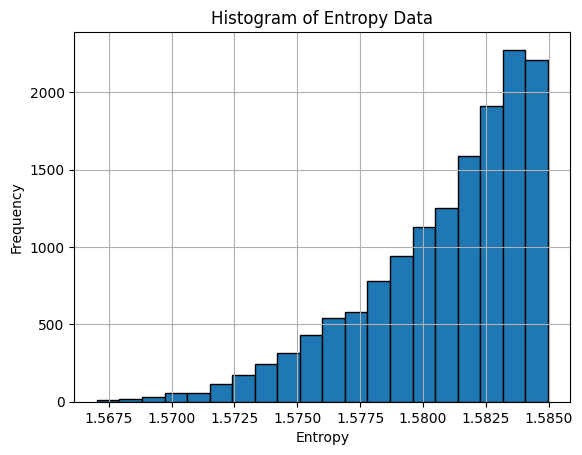

In [19]:
notnoisyembed = embeddings[db2.labels_ != -1,]

kmeans.fit(notnoisyembed)

centers = kmeans.cluster_centers_

(a,b) = embeddings.shape
classprobs = np.zeros((a,3))
tweet_clusters = np.zeros((a,), dtype = np.int64)
WSS1 =0

for i in range(a):
    for j in range(3):
        classprobs[i,j] = 1-np.dot(embeddings[i],centers[j])/np.clip(
            (np.linalg.norm(embeddings[i])*np.linalg.norm(centers[j])), a_min = 1e-15, a_max = float("inf"))
    tweet_clusters[i] = np.argmin(classprobs[i])
    WSS1 += min(classprobs[i])
    classprobs[i] = 1/np.exp(classprobs[i])
    sumofinv = sum(classprobs[i])
    classprobs[i] = classprobs[i]/sumofinv

homogeneity = metrics.homogeneity_score(tweetdataraw['sentiment'], tweet_clusters)
completeness = metrics.completeness_score(tweetdataraw['sentiment'], tweet_clusters)
v_measure = metrics.v_measure_score(tweetdataraw['sentiment'], tweet_clusters)
adjusted_rand_index = metrics.adjusted_rand_score(tweetdataraw['sentiment'], tweet_clusters)
silhouette_coefficient = metrics.silhouette_score(embeddings, tweet_clusters, sample_size=2000, metric = 'cosine')



print("--------The following are scores for DBSCAN + k means clustering (W2V)------------")
print(f"Homogeneity: {homogeneity:.4f}")
print(f"Completeness: {completeness:.4f}")
print(f"V-Measure: {v_measure:.4f}")
print(f"Adjusted Rand Index: {adjusted_rand_index:.4f}")
print(f"Silhouette Coefficient:{silhouette_coefficient:.4f}")
cm = confusion_matrix(tweetdataraw['sentiment'], tweet_clusters)
print(cm)
print(f"Within SS is: {WSS1}")

certaintylist = []
for i in range(a):
    certaintylist.append(entropy(classprobs[i])) ##more entropy, less certain

plt.hist(certaintylist, bins=20, edgecolor='black')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.title('Histogram of Entropy Data')
plt.grid(True)
plt.show()
##plot only confident entries
confident = (np.array(certaintylist) < np.percentile(certaintylist, 25))

Birch model but with DBSCAN implemented and the following cluster visualisation.



--------The following are scores for DBSCAN + Birch (W2V)------------
Homogeneity: 0.0547
Completeness: 0.0683
V-Measure: 0.0607
Adjusted Random Index: 0.1336
Silhouette Coefficient:0.2698
[[1110 1095  157]
 [2229 6926   23]
 [1478 1464  157]]
Within SS is: 1509.6889382356542
3660
3660
3660


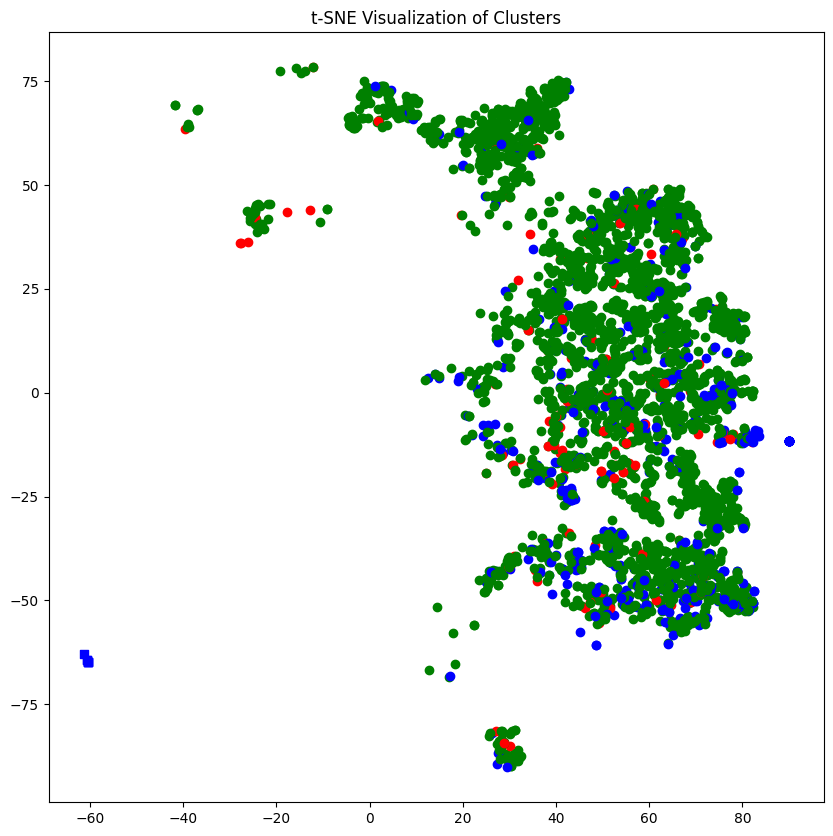

In [20]:
bchModel = Birch(n_clusters = 3, compute_labels = True, threshold=0.45, branching_factor=50)
bchModel.fit(notnoisyembed)
centers = bchModel.subcluster_centers_
(a,b) = embeddings.shape
classprobs = np.zeros((a,3))
tweet_clusters = np.zeros((a,), dtype = np.int64)
WSS2 = 0

for i in range(a):
    for j in range(3):
        classprobs[i,j] = 1-np.dot(embeddings[i],centers[j])/np.clip(
            (np.linalg.norm(embeddings[i])*np.linalg.norm(centers[j])), a_min = 1e-15, a_max = float("inf"))
    tweet_clusters[i] = np.argmin(classprobs[i])
    WSS2 += min(classprobs[i])
    classprobs[i] = 1/np.exp(classprobs[i]) ##people use softmax functions apparently
    sumofinv = sum(classprobs[i])
    classprobs[i] = classprobs[i]/sumofinv

homogeneity = metrics.homogeneity_score(tweetdataraw['sentiment'], tweet_clusters)
completeness = metrics.completeness_score(tweetdataraw['sentiment'], tweet_clusters)
v_measure = metrics.v_measure_score(tweetdataraw['sentiment'], tweet_clusters)
adjusted_rand_index = metrics.adjusted_rand_score(tweetdataraw['sentiment'], tweet_clusters)
silhouette_coefficient = metrics.silhouette_score(embeddings, tweet_clusters, sample_size=2000, metric = 'cosine')

print("--------The following are scores for DBSCAN + Birch (W2V)------------")
print(f"Homogeneity: {homogeneity:.4f}")
print(f"Completeness: {completeness:.4f}")
print(f"V-Measure: {v_measure:.4f}")
print(f"Adjusted Rand Index: {adjusted_rand_index:.4f}")
print(f"Silhouette Coefficient:{silhouette_coefficient:.4f}")
cm = confusion_matrix(tweetdataraw['sentiment'], tweet_clusters)
print(cm)
print(f"Within SS is: {WSS2}")

certaintylist = []
for i in range(a):
    certaintylist.append(entropy(classprobs[i])) ##more entropy, less certain

##plot only confident entries
confident = (np.array(certaintylist) < np.percentile(certaintylist, 25))
visualiseclusters(X_embedded[confident], np.array(tweetdataraw['sentiment'][confident]), tweet_clusters[confident])





Save models if they seem to be giving good performance metrics.

In [21]:
import pickle


with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

with open('birch_model.pkl', 'wb') as f:
    pickle.dump(bchModel, f)

with open('skip_gram_model.pkl', 'wb') as f:
    pickle.dump(skip_gram_model, f)

with open('dbscan_model.pkl', 'wb') as f:
    pickle.dump(db2, f)

print("Models saved successfully!")

Models saved successfully!


### The sections below are to test our saved models: so that we can save our performance scores for each model.


To run the metrics, restart the runtime and run the code only until the 'Parameter' cell, then run the cells below. This hopes to avoid any object assignment issues, and we can just observe our models from here.

In [1]:
import pickle

# Load the models
with open('TSNE.pkl', 'rb') as f:
    tsne = pickle.load(f)

with open('birch_model_saved.pkl', 'rb') as f:
    bchModel = pickle.load(f)

with open('skip_gram_model_saved.pkl', 'rb') as f:
    skip_gram_model = pickle.load(f)

with open('dbscan_model_saved.pkl', 'rb') as f:
    db2 = pickle.load(f)

In [24]:
embeddings = []

for tweet in tweetdataraw['text']:
    words = tweet.split()
    in_vocab_words = [word for word in words if word in skip_gram_model.wv.key_to_index]
    if in_vocab_words:
        embedding = np.mean([skip_gram_model.wv[word] for word in in_vocab_words], axis=0)
        embeddings.append(embedding)
    else:
        embeddings.append(np.zeros((dim_param,),dtype=np.float32))

embeddings = np.array(embeddings)

In [25]:
tfidf_vectorizer = TfidfVectorizer(sublinear_tf = True, ngram_range = (1,2))
tfidf_matrix = tfidf_vectorizer.fit_transform(tweetdataraw['text'])

lsa = make_pipeline(TruncatedSVD(n_components=dim_param), Normalizer(copy=False))
tweet_lsa = lsa.fit_transform(tfidf_matrix)

tweet_clusters = db2.labels_
homogeneity = metrics.homogeneity_score(tweetdataraw['airline_sentiment'], tweet_clusters)
completeness = metrics.completeness_score(tweetdataraw['airline_sentiment'], tweet_clusters)
v_measure = metrics.v_measure_score(tweetdataraw['airline_sentiment'], tweet_clusters)
adjusted_rand_index = metrics.adjusted_rand_score(tweetdataraw['sentiment'], tweet_clusters)
silhouette_coefficient = metrics.silhouette_score(tweet_lsa, tweet_clusters, sample_size=2000, metric = 'cosine')

print("--------The following are scores for naive DBSCAN clustering (TFIDF)------------")
print(f"Homogeneity: {homogeneity:.4f}")
print(f"Completeness: {completeness:.4f}")
print(f"V-Measure: {v_measure:.4f}")
print(f"Adjusted Rand Index: {adjusted_rand_index:.4f}")
print(f"Silhouette Coefficient:{silhouette_coefficient:.4f}")
print(sum(db2.labels_ == -1))
print(len(set(db2.labels_)))

--------The following are scores for naive DBSCAN clustering (TFIDF)------------
Homogeneity: 0.0799
Completeness: 0.1271
V-Measure: 0.0981
Adjusted Random Index: 0.1294
Silhouette Coefficient:-0.0876
12984
26


--------The following are scores for DBSCAN + Birch (W2V)------------
Homogeneity: 0.0520
Completeness: 0.1074
V-Measure: 0.0701
Adjusted Random Index: 0.1128
Silhouette Coefficient:0.5096
[[ 604 1645  113]
 [ 225 8568  385]
 [ 423 2649   27]]
Within SS is: 870.2643193267289


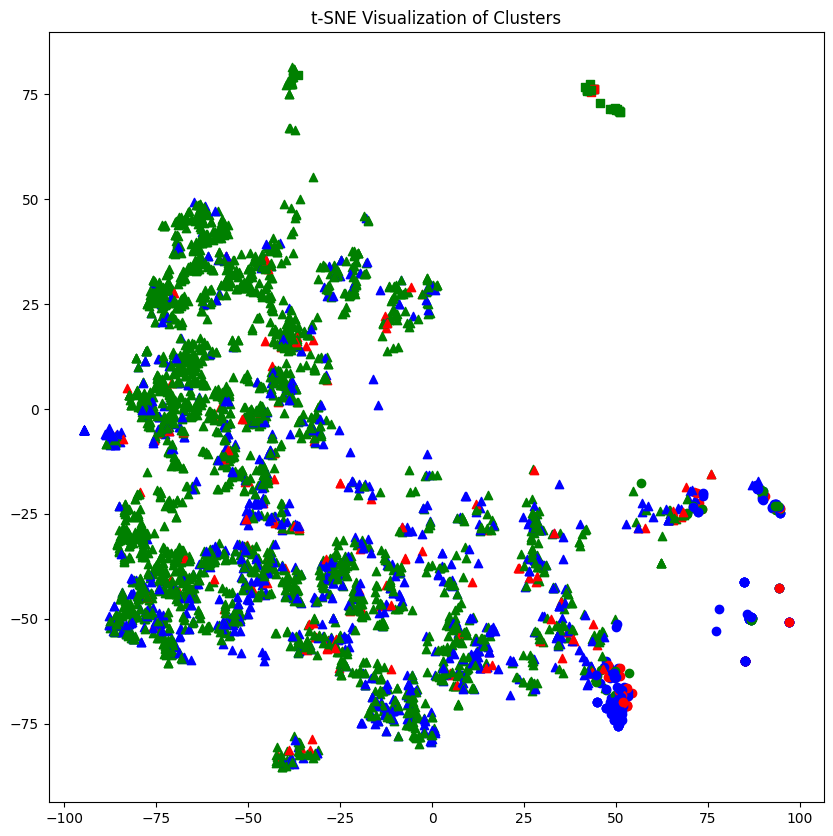

In [30]:
notnoisyembed = embeddings[db2.labels_ != -1,]


bchModel.fit(notnoisyembed)
centers = bchModel.subcluster_centers_
(a,b) = embeddings.shape
classprobs = np.zeros((a,3))
tweet_clusters = np.zeros((a,), dtype = np.int64)
WSS2 = 0

for i in range(a):
    for j in range(3):
        classprobs[i,j] = 1-np.dot(embeddings[i],centers[j])/np.clip(
            (np.linalg.norm(embeddings[i])*np.linalg.norm(centers[j])), a_min = 1e-15, a_max = float("inf"))
    tweet_clusters[i] = np.argmin(classprobs[i])
    WSS2 += min(classprobs[i])
    classprobs[i] = 1/np.exp(classprobs[i]) ##people use softmax functions apparently
    sumofinv = sum(classprobs[i])
    classprobs[i] = classprobs[i]/sumofinv

homogeneity = metrics.homogeneity_score(tweetdataraw['sentiment'], tweet_clusters)
completeness = metrics.completeness_score(tweetdataraw['sentiment'], tweet_clusters)
v_measure = metrics.v_measure_score(tweetdataraw['sentiment'], tweet_clusters)
adjusted_rand_index = metrics.adjusted_rand_score(tweetdataraw['sentiment'], tweet_clusters)
silhouette_coefficient = metrics.silhouette_score(embeddings, tweet_clusters, sample_size=2000, metric = 'cosine')

print("--------The following are scores for DBSCAN + Birch (W2V)------------")
print(f"Homogeneity: {homogeneity:.4f}")
print(f"Completeness: {completeness:.4f}")
print(f"V-Measure: {v_measure:.4f}")
print(f"Adjusted Rand Index: {adjusted_rand_index:.4f}")
print(f"Silhouette Coefficient:{silhouette_coefficient:.4f}")
cm = confusion_matrix(tweetdataraw['sentiment'], tweet_clusters)
print(cm)
print(f"Within SS is: {WSS2}")

certaintylist = []
for i in range(a):
    certaintylist.append(entropy(classprobs[i])) ##more entropy, less certain

##plot only confident entries
confident = (np.array(certaintylist) < np.percentile(certaintylist, 25))
X_embedded = tsne.fit_transform(embeddings)
visualiseclusters(X_embedded[confident], np.array(tweetdataraw['sentiment'][confident]), tweet_clusters[confident])

